In [74]:
# Import necessary library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
file_path = '/content/Video Games Sales.csv'
video_games_sales = pd.read_csv(file_path)
video_games_sales.head()

,index,Rank,Game Title,Platform,Year,Genre,Publisher,North America,Europe,Japan,Rest of World,Global,Review
0,0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,40.43,28.39,3.77,8.54,81.12,76.28
1,1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,91.00
2,2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,14.50,12.22,3.63,3.21,33.55,82.07
3,3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,14.82,10.51,3.18,3.01,31.52,82.65
4,4,5,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26,88.00


## 1)Phân tích thống kê trên dữ liệu, vẽ các đồ thị để hiểu bài toán, hiểu dữ liệu. Tìm hiểu các đặc trưng và đánh gía vai trò của các đặc trưng đối với mục tiêu bài toán

In [75]:
# Basic Data Analysis
summary_stats = video_games_sales.describe()
missing_values = video_games_sales.isnull().sum()
print(summary_stats, missing_values)

           index       Rank         Year  North America       Europe  \
count  1907.0000  1907.0000  1878.000000    1907.000000  1907.000000   
mean    953.0000   954.0000  2003.766773       1.258789     0.706675   
std     550.6478   550.6478     5.895369       1.956560     1.148904   
min       0.0000     1.0000  1983.000000       0.000000     0.000000   
25%     476.5000   477.5000  2000.000000       0.510000     0.230000   
50%     953.0000   954.0000  2005.000000       0.810000     0.440000   
75%    1429.5000  1430.5000  2008.000000       1.375000     0.810000   
max    1906.0000  1907.0000  2012.000000      40.430000    28.390000   

             Japan  Rest of World       Global       Review  
count  1907.000000    1907.000000  1907.000000  1907.000000  
mean      0.317493       0.206471     2.489240    79.038977  
std       0.724945       0.343093     3.563159    10.616899  
min       0.000000       0.000000     0.830000    30.500000  
25%       0.000000       0.060000     1.1

In [76]:
# Data Cleaning
video_games_sales.dropna(inplace=True)
video_games_sales['Year'] = pd.to_numeric(video_games_sales['Year'], errors='coerce')
video_games_sales['Global'] = pd.to_numeric(video_games_sales['Global'], errors='coerce')
video_games_sales.dropna(subset=['Year'], inplace=True)
video_games_sales['Global'].fillna(video_games_sales['Global'].median(), inplace=True)

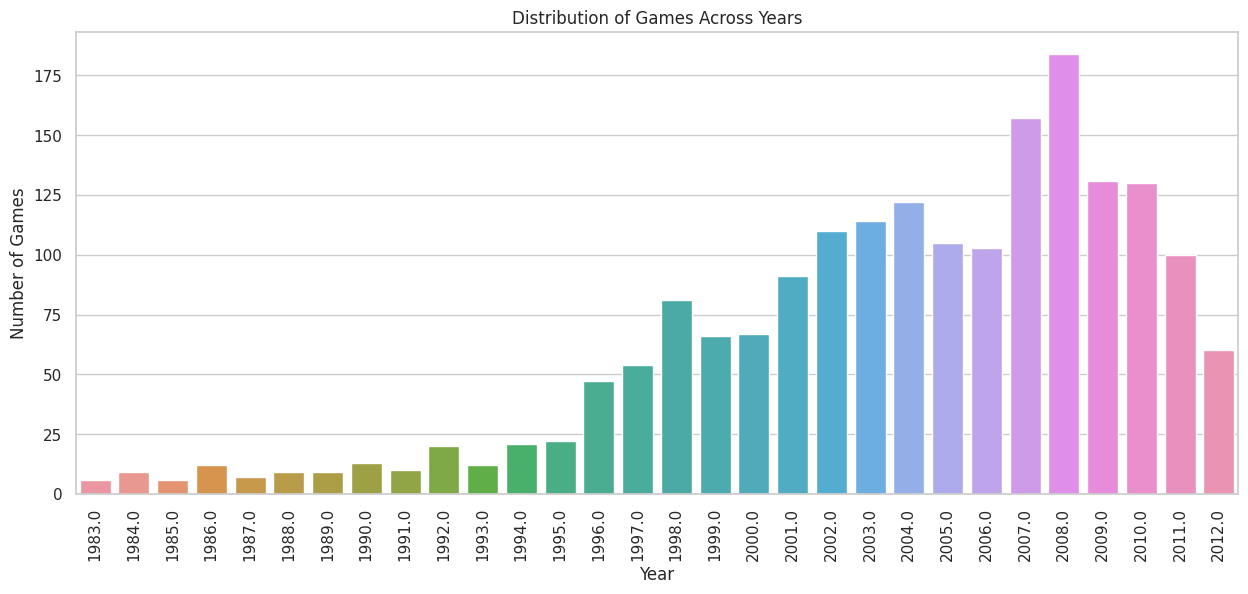

In [77]:
sns.set(style="whitegrid")

# Distribution of games across years
plt.figure(figsize=(15, 6))
sns.countplot(x='Year', data=video_games_sales)
plt.xticks(rotation=90)
plt.title('Distribution of Games Across Years')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.show()

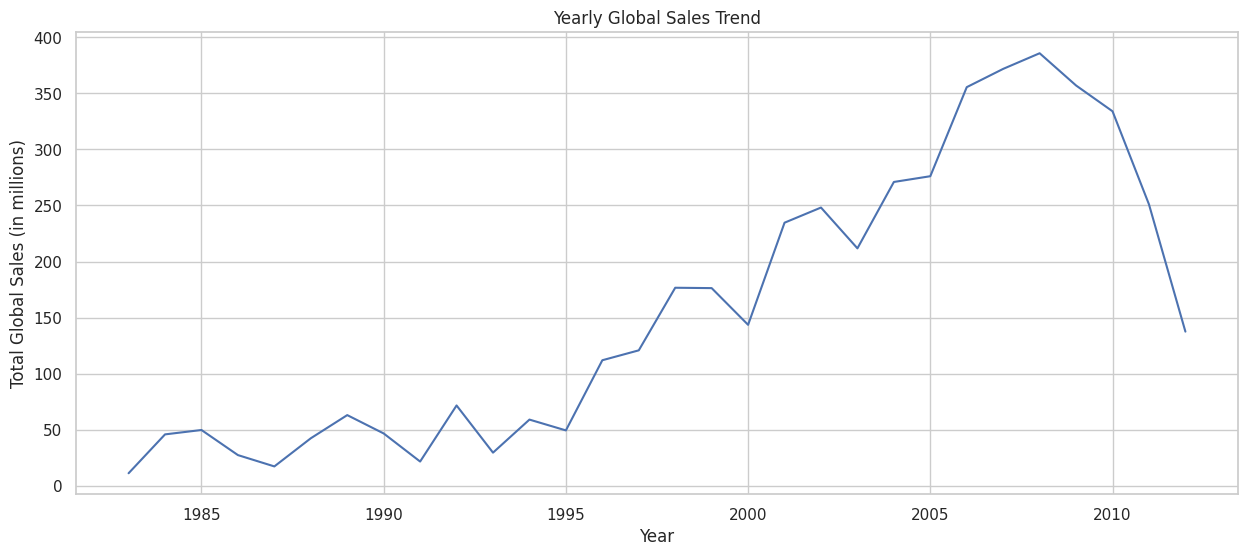

In [78]:
# Time Series Analysis: Yearly Global Sales Trend
plt.figure(figsize=(15, 6))
yearly_sales = video_games_sales.groupby('Year')['Global'].sum()
sns.lineplot(x=yearly_sales.index, y=yearly_sales.values)
plt.title('Yearly Global Sales Trend')
plt.xlabel('Year')
plt.ylabel('Total Global Sales (in millions)')
plt.show()

**Từ khoảng giữa những năm 1980 đến đầu những năm 2000, có một xu hướng tăng trưởng ổn định trong doanh số bán hàng toàn cầu. Có một đỉnh cao rõ rệt trong doanh số vào khoảng giữa những năm 2000, điều này có thể phản ánh sự ra đời của các nền tảng trò chơi mới, sự phổ biến của các tựa game chủ chốt, hoặc sự tăng trưởng của thị trường trò chơi điện tử nói chung. Sau đỉnh điểm đó, có một sự sụt giảm rất lớn trong doanh số, có thể do các yếu tố như bão hòa thị trường, sự chuyển đổi sang các nền tảng trò chơi kỹ thuật số hoặc di động, hoặc sự cạnh tranh từ các hình thức giải trí khác.**

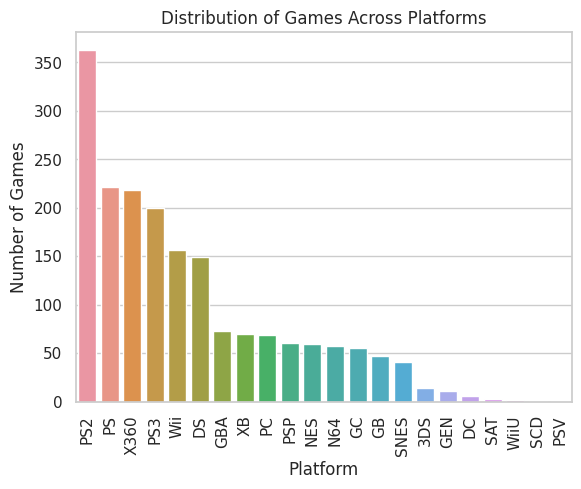

In [79]:
# Distribution of games across platforms
sns.countplot(x='Platform', data=video_games_sales, order = video_games_sales['Platform'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Distribution of Games Across Platforms')
plt.xlabel('Platform')
plt.ylabel('Number of Games')
plt.show()

**Biểu đồ thể hiện sự phân bố số lượng game trên các nền tảng khác nhau. Một số nền tảng đặt biệt nổi bật với số lượng game lớn, cho thấy sự phổ biến của chúng trong ngành công nghệ game.**

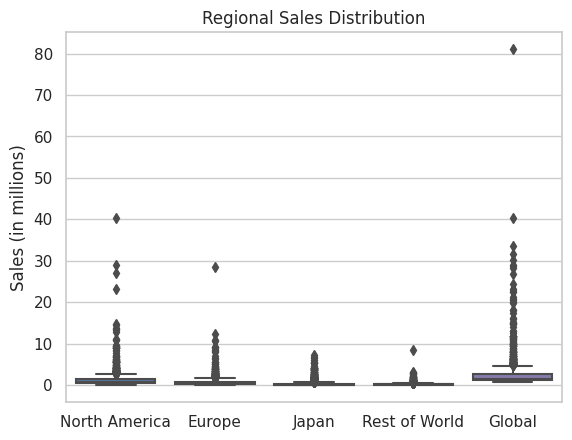

In [80]:
# Boxplot for regional sales distribution
sns.boxplot(data=video_games_sales[['North America', 'Europe', 'Japan', 'Rest of World', 'Global']])
plt.title('Regional Sales Distribution')
plt.ylabel('Sales (in millions)')
plt.show()

**Biểu đồ boxplot trên cho thấy sự phân bố doanh số trong các khu vực như Bắc Mỹ, Châu Âu, Nhật Bản, phần còn lại của thế giới, cũng như doanh số toàn cầu. Có thể thấy rằng doanh số ở Bắc Mỹ thường cao hơn so với các khu vực khác, điều này phản ánh tầm quan trọng của thị trường này trong ngành công nghiệp game.**

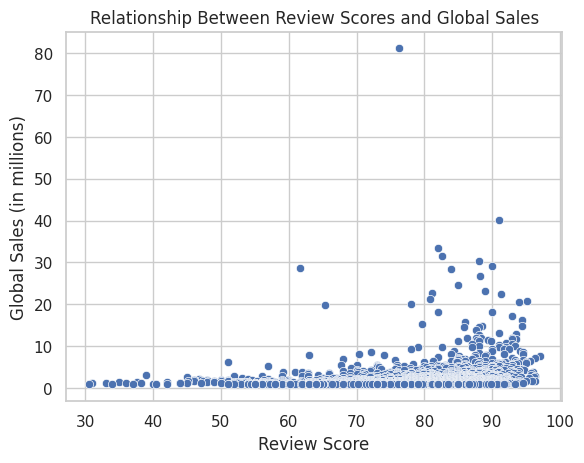

In [81]:
# Scatter plot for relationship between Review scores and Global sales
sns.scatterplot(x='Review', y='Global', data=video_games_sales)
plt.title('Relationship Between Review Scores and Global Sales')
plt.xlabel('Review Score')
plt.ylabel('Global Sales (in millions)')
plt.show()

**Biểu đồ scatter plot cho thấy mối quan hệ giữa điểm đánh giá và doanh số toàn cầu của các trò chơi video. Từ biểu đồ, ta có thể quan sát rằng không có một mối quan hệ rõ ràng giữa điểm đánh giá và doanh số. Mặc dù có một số trò chơi có điểm đánh giá cao và doanh số cao, nhưng cũng có nhiều trường hợp trò chơi có điểm đánh giá cao nhưng doanh số không quá ấn tượng, và ngược lại.**

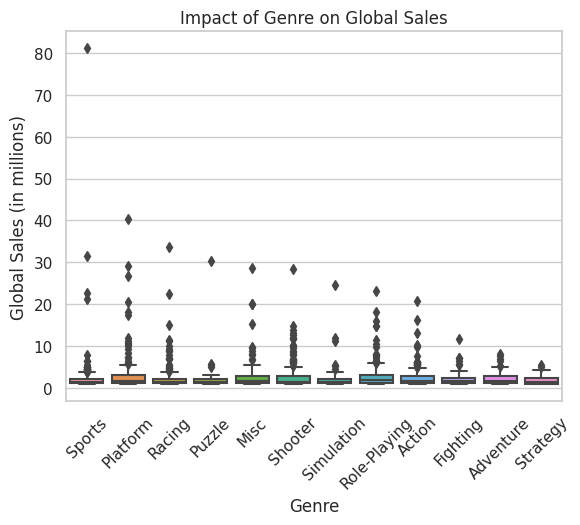

In [82]:
# Genre distribution and its impact on sales
sns.boxplot(x='Genre', y='Global', data=video_games_sales)
plt.xticks(rotation=45)
plt.title('Impact of Genre on Global Sales')
plt.xlabel('Genre')
plt.ylabel('Global Sales (in millions)')
plt.show()

**Biểu đồ boxplot trên thể hiện ảnh hưởng của thể loại game lên doanh số toàn cầu. Từ biểu đồ, ta có thể thấy rằng có sự khác biệt về doanh số giữa các thể loại. Một số thể loại có doanh số trung bình và phạm vi cao hơn so với những thể loại khác, điều này có thể phản ánh sự ưa chuộng của thị trường đối với những thể loại cụ thể.**

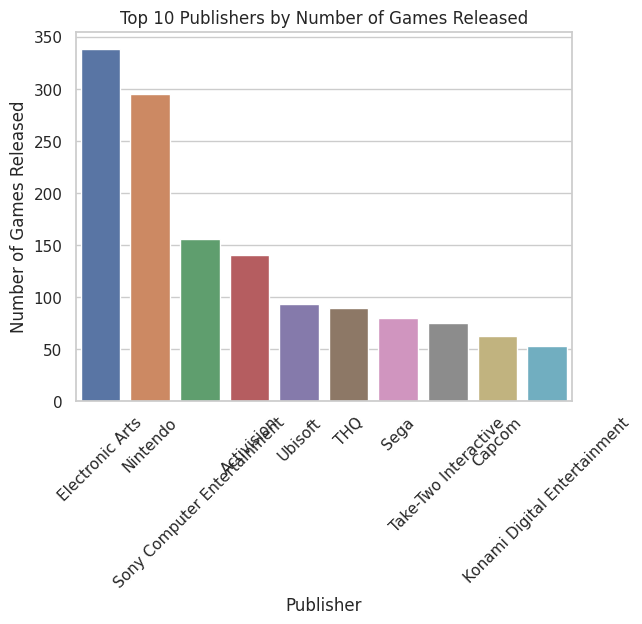

In [83]:
# Publisher analysis in terms of number of games released
top_publishers = video_games_sales['Publisher'].value_counts().head(10)
sns.barplot(x=top_publishers.index, y=top_publishers.values)
plt.xticks(rotation=45)
plt.title('Top 10 Publishers by Number of Games Released')
plt.xlabel('Publisher')
plt.ylabel('Number of Games Released')
plt.show()

**Biểu đồ bar trên cho thấy top 10 nhà xuất bản với số lượng game phát hành nhiều nhất. Các nhà xuất bản này có thể coi là những tên tuổi lớn trong ngành công nghiệp game, với số lượng phát hành đáng kể.**

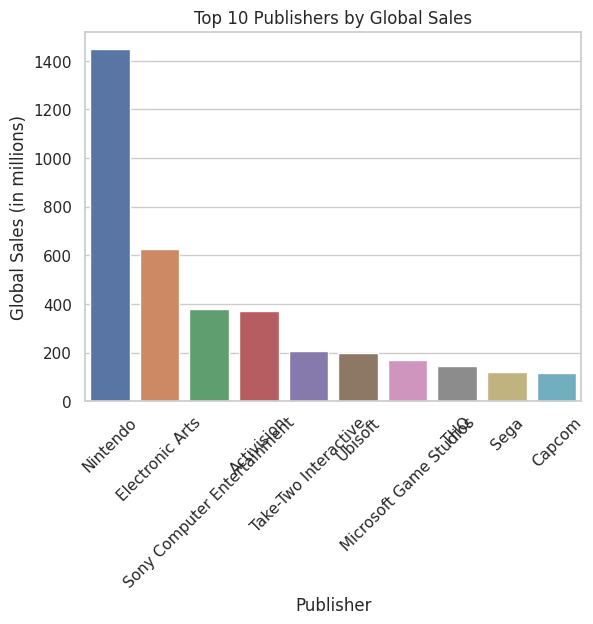

In [84]:
# Publisher analysis in terms of sales performance
top_publishers_sales = video_games_sales.groupby('Publisher')['Global'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_publishers_sales.index, y=top_publishers_sales.values)
plt.xticks(rotation=45)
plt.title('Top 10 Publishers by Global Sales')
plt.xlabel('Publisher')
plt.ylabel('Global Sales (in millions)')
plt.show()

**Nintendo có vị thế thống trị rõ ràng trên thị trường với doanh số bán hàng toàn cầu vượt trội so với các nhà xuất bản khác. Electronic Arts và Sony Computer Entertainment đứng thứ hai và thứ ba, tương ứng, cho thấy sự cạnh tranh mạnh mẽ giữa các công ty lớn trong ngành công nghiệp game.Có sự chênh lệch đáng kể trong doanh số bán hàng giữa các nhà xuất bản hàng đầu và những nhà xuất bản khác, điều này có thể phản ánh sự khác biệt trong cả lượng trò chơi được phát hành và mức độ thành công của các trò chơi đó.**

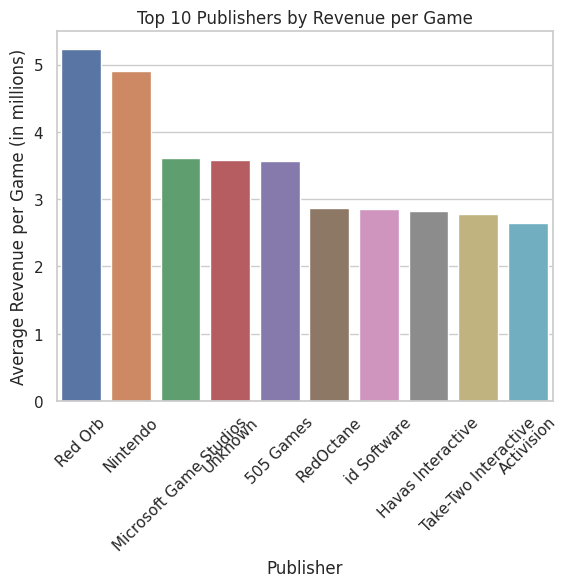

In [85]:
# Feature Engineering: Revenue per Game for each Publisher
video_games_sales['Revenue per Game'] = video_games_sales.groupby('Publisher')['Global'].transform('sum') / video_games_sales.groupby('Publisher')['Global'].transform('count')

top_publishers_rpg = video_games_sales.groupby('Publisher')['Revenue per Game'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_publishers_rpg.index, y=top_publishers_rpg.values)
plt.xticks(rotation=45)
plt.title('Top 10 Publishers by Revenue per Game')
plt.xlabel('Publisher')
plt.ylabel('Average Revenue per Game (in millions)')
plt.show()

**Red Orb dẫn đầu danh sách với mức doanh thu trung bình trên mỗi trò chơi cao nhất, điều này cho thấy họ có thể phát hành ít trò chơi hơn nhưng mỗi trò chơi lại rất thành công về mặt doanh thu. Nintendo, mặc dù không còn giữ vị trí số một như trong biểu đồ doanh số tổng thể, vẫn có mức doanh thu cao trên mỗi trò chơi, cho thấy sức mạnh của các tựa game họ phát hành. Microsoft Game Studios, 505 Games, RedOctane, id Software, Havas Interactive, Take-Two Interactive, Activision, và Enix Corporation cũng nằm trong top 10. Mặc dù không có doanh số tổng thể cao như Nintendo hoặc Electronic Arts trong biểu đồ trước, nhưng khi xem xét doanh thu trung bình trên mỗi trò chơi, họ lại thể hiện mức độ thành công đáng kể. Sự biến động trong danh sách top nhà xuất bản khi xét theo doanh thu trung bình trên mỗi trò chơi so với doanh thu tổng cảm nhận được rõ rệt, cho thấy một số nhà xuất bản có chiến lược phát hành ít trò chơi hơn nhưng mỗi trò chơi lại mang lại doanh thu cao.**

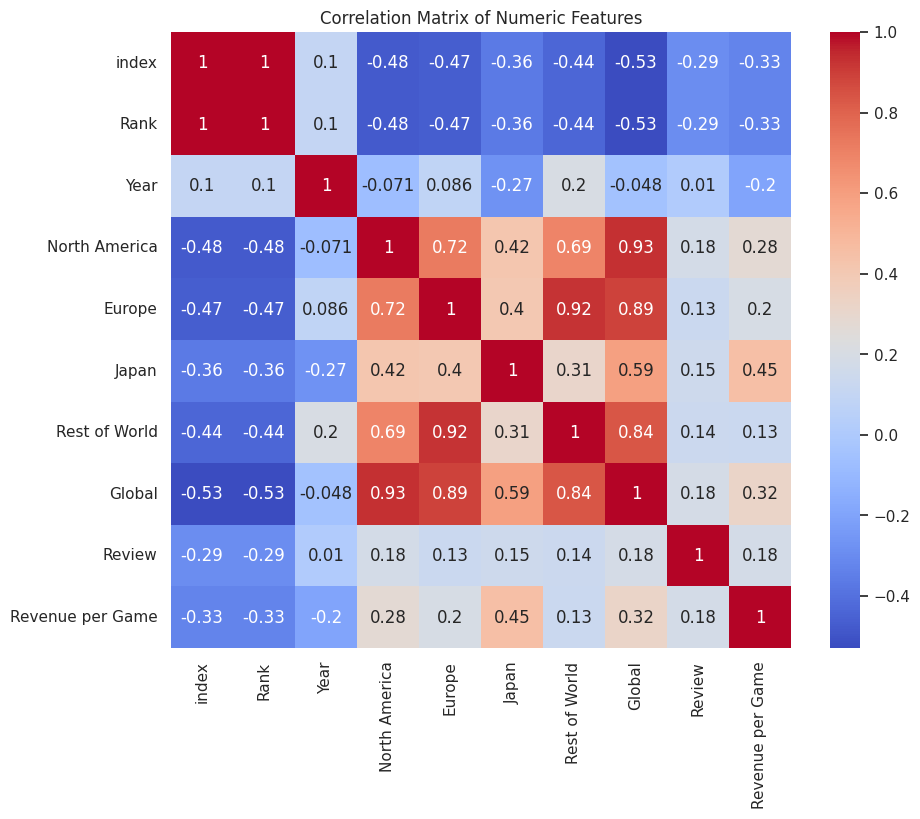

In [86]:
# Select only numeric columns for correlation
numeric_columns = video_games_sales.select_dtypes(include=[np.number])
correlation_matrix = numeric_columns.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Numeric Features")
plt.show()

**Doanh số bán hàng toàn cầu có tương quan rất cao với doanh số ở Bắc Mỹ và Châu Âu, cho thấy rằng những thị trường này là những động lực chính cho doanh số bán hàng toàn cầu. Sự tương quan cao giữa doanh số ở Châu Âu và phần còn lại của thế giới cũng cho thấy sự phụ thuộc lẫn nhau hoặc xu hướng tiêu dùng tương tự giữa các thị trường này.**

## 2)Ứng dụng các mô hình học máy cơ bản để giải quyết bài toán, bao gồm cả các mô hình thuộc Ensemble Learing

In [87]:
# Data Preprocessing for Modeling
video_games_sales.drop(columns=['index'], inplace=True)
imputer = SimpleImputer(strategy='median')
video_games_sales['Year'] = imputer.fit_transform(video_games_sales[['Year']]).ravel()
imputer = SimpleImputer(strategy='most_frequent')
video_games_sales['Publisher'] = imputer.fit_transform(video_games_sales[['Publisher']]).ravel()

# Encoding and Normalizing
numerical_features = ['Year', 'North America', 'Europe', 'Japan', 'Rest of World', 'Review']
categorical_features = ['Game Title', 'Platform', 'Genre', 'Publisher']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Splitting Data
X = video_games_sales.drop('Global', axis=1)
y = video_games_sales['Global']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [88]:
# Model Training and Evaluation
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'KNN': KNeighborsRegressor(),
    'SVR': SVR()
}

results = {}
for name, model in models.items():
    model.fit(X_train_preprocessed, y_train)
    predictions = model.predict(X_test_preprocessed)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    results[name] = {'MSE': mse, 'R2': r2}

results_df = pd.DataFrame(results).T

results_df

,MSE,R2
Linear Regression,0.000075,0.999982
Decision Tree,0.237643,0.943116
Random Forest,0.086438,0.979310
Gradient Boosting,0.053127,0.987283
KNN,0.607659,0.854547
SVR,0.316009,0.924358


**Các mô hình ensemble như Random Forest và Gradient Boosting cho thấy hiệu suất tốt trong việc nắm bắt các xu hướng phức tạp trong dữ liệu, trong khi Linear Regression và Ridge Regression cho thấy hiệu suất rất cao có thể do overfitting. Mô hình KNN và SVR cho kết quả kém hơn, có thể do cách chúng xử lý dữ liệu hoặc cần điều chỉnh tham số tốt hơn.**

## 3)Sử dụng Feed Forward Neural Network và Reccurent Neural Network để giải quyết bài toán

In [89]:
# Convert the preprocessed data to dense format
X_train_dense = X_train_preprocessed.toarray()
X_test_dense = X_test_preprocessed.toarray()

# Feed Forward Neural Network Model
ffnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_preprocessed.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])
ffnn.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
history_ffnn = ffnn.fit(
    X_train_dense, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=0
)

# Predict and Evaluate FFNN
y_pred_ffnn = ffnn.predict(X_test_dense)
mse_ffnn = mean_squared_error(y_test, y_pred_ffnn.flatten())
r2_ffnn = r2_score(y_test, y_pred_ffnn.flatten())

print("Feed Forward Neural Network - MSE:", mse_ffnn, "R2 Score:", r2_ffnn)

12/12 [==============================] - 0s 4ms/step
Feed Forward Neural Network - MSE: 0.07393553483908032 R2 Score: 0.9823023573847053


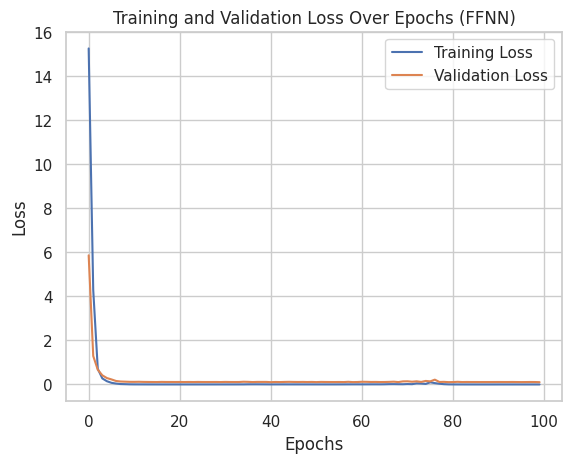

In [90]:
# Loss diagram FFNN
plt.plot(history_ffnn.history['loss'], label='Training Loss')
plt.plot(history_ffnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs (FFNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [91]:
# Reshape data for RNN
n_features = X_train_dense.shape[1]
X_train_rnn = X_train_dense.reshape((X_train_dense.shape[0], 1, n_features))
X_test_rnn = X_test_dense.reshape((X_test_dense.shape[0], 1, n_features))

# Recurrent Neural Network Model
rnn = Sequential([
    SimpleRNN(128, activation='relu', input_shape=(1, n_features)),
    Dense(64, activation='relu'),
    Dense(1)
])
rnn.compile(optimizer='adam', loss='mean_squared_error')

# Train RNN
history_rnn = rnn.fit(
    X_train_rnn, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=0)

# Predict and Evaluate RNN
y_pred_rnn = rnn.predict(X_test_rnn)
mse_rnn = mean_squared_error(y_test, y_pred_rnn.flatten())
r2_rnn = r2_score(y_test, y_pred_rnn.flatten())

print("Recurrent Neural Network - MSE:", mse_rnn, "R2 Score:", r2_rnn)

12/12 [==============================] - 1s 6ms/step
Recurrent Neural Network - MSE: 0.07470014306443855 R2 Score: 0.9821193362820304


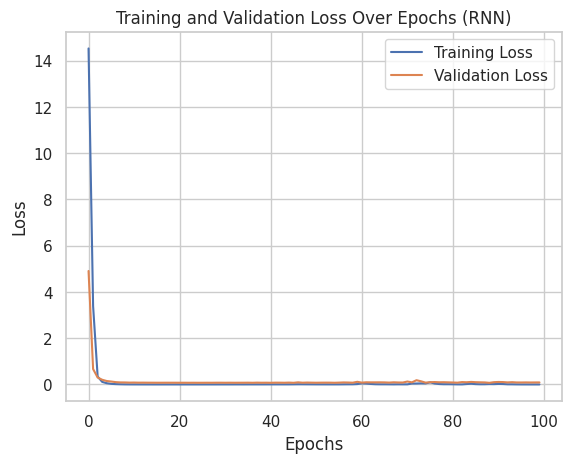

In [92]:
# Loss diagram RNN
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs (RNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 4)Áp dụng các kỹ thuật tránh Overfiting trên các mô hình của câu (2) và câu (3) để giải quyết bài toán

In [95]:
# Improve Feed Forward Neural Network
ffnn_updated = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_preprocessed.shape[1],), kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1)
])
ffnn_updated.compile(optimizer='adam', loss='mean_squared_error')

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Training the model
history_ffnn_updated = ffnn_updated.fit(
    X_train_dense, y_train,
    validation_split=0.2,
    epochs=100,
    callbacks=[early_stopping],
    batch_size=32,
    verbose=0
)

# Predict and Evaluate FFNN
y_pred_ffnn_updated = ffnn_updated.predict(X_test_dense)
mse_ffnn_updated = mean_squared_error(y_test, y_pred_ffnn_updated.flatten())
r2_ffnn_updated = r2_score(y_test, y_pred_ffnn_updated.flatten())

print("Feed Forward Neural Network - MSE:", mse_ffnn, "R2 Score:", r2_ffnn)
print("Feed Forward Neural Network V2 - MSE:", mse_ffnn_updated, "R2 Score:", r2_ffnn_updated)

Restoring model weights from the end of the best epoch: 24.
Epoch 34: early stopping
12/12 [==============================] - 0s 2ms/step
Feed Forward Neural Network - MSE: 0.07393553483908032 R2 Score: 0.9823023573847053
Feed Forward Neural Network V2 - MSE: 0.4390318806415497 R2 Score: 0.8949107579024645


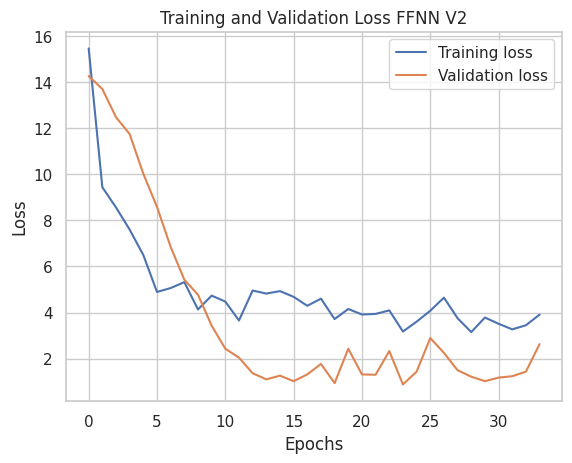

In [96]:
# Loss diagram improve FFNN
plt.plot(history_ffnn_updated.history['loss'], label='Training loss')
plt.plot(history_ffnn_updated.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss FFNN V2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [98]:
# Improve Recurrent Neural Network
rnn_updated = Sequential([
    LSTM(128, activation='relu', input_shape=(1, n_features), kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1)
])

# Compile the model
rnn_updated.compile(optimizer='adam', loss='mean_squared_error')

# Train RNN
history_rnn_updated = rnn_updated.fit(
    X_train_rnn, y_train,
    validation_split=0.2,
    epochs=100,
    callbacks=[early_stopping],
    batch_size=32,
    verbose=0
)

# Predict and Evaluate the RNN
y_pred_rnn_updated = rnn_updated.predict(X_test_rnn)
mse_rnn_updated = mean_squared_error(y_test, y_pred_rnn_updated.flatten())
r2_rnn_updated = r2_score(y_test, y_pred_rnn_updated.flatten())

print("Recurrent Neural Network - MSE:", mse_rnn, "R2 Score:", r2_rnn)
print("Recurrent Neural Network V2 - MSE:", mse_rnn_updated, "R2 Score:", r2_rnn_updated)

Restoring model weights from the end of the best epoch: 19.
Epoch 29: early stopping
12/12 [==============================] - 0s 5ms/step
Recurrent Neural Network - MSE: 0.07470014306443855 R2 Score: 0.9821193362820304
Recurrent Neural Network V2 - MSE: 0.5766543499953658 R2 Score: 0.8619686376654334


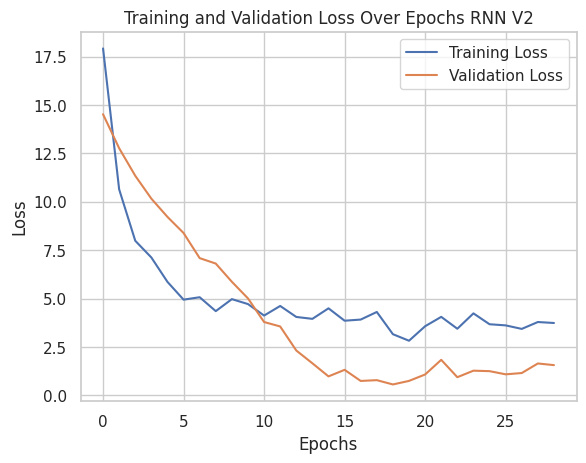

In [99]:
# Loss diagram RNN V2
plt.plot(history_rnn_updated.history['loss'], label='Training Loss')
plt.plot(history_rnn_updated.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs RNN V2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 5)Sau khi huấn luyện xong mô hình thì muốn cải thiện độ chính xác, ta sẽ làm gì để giải quyết nó? Phân tích các trường hợp sai, đề ra giải pháp và thực hiện nó, sau đó đánh giá xem có cải tiến so với trước không

**Các cách cải thiện độ chính xác:**
**1) Thu thập thêm dữ liệu: Có thể mô hình cần nhiều dữ liệu hơn để học được các mẫu phức tạp.**

**2) Tinh chỉnh các tham số: Điều chỉnh các tham số của mô hình có thể giúp cải thiện hiệu suất.**

**3) Chọn mô hình khác: Có thể mô hình hiện tại không phù hợp với loại dữ liệu đang làm việc.**

**4) Xử lý dữ liệu: Cải thiện chất lượng dữ liệu thông qua việc xử lý nhiễu, loại bỏ giá trị ngoại lệ, hoặc áp dụng các kỹ thuật tính toán khác như chọn đặc trưng (feature selection) hoặc giảm chiều dữ liệu.**


In [100]:
# Refine the Random Forest model
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           scoring='neg_mean_squared_error',
                           verbose=1)

grid_search.fit(X_train_preprocessed, y_train)

# Best model picker
best_rf = grid_search.best_estimator_

# Predict on test set
y_pred_best_rf = best_rf.predict(X_test_preprocessed)

# Evaluate new model
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)


print("Improved Random Forest - MSE:", mse_best_rf, "R2 Score:", r2_best_rf)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Improved Random Forest - MSE: 0.09308284953507093 R2 Score: 0.9777191440047013


**Kết quả tương tự như phiên bản ban đầu nhưng hơi thấp hơn một chút cả về MSE và R2 Score. Điều này cho thấy rằng việc tinh chỉnh siêu tham số không mang lại lợi ích đáng kể so với mô hình ban đầu trong trường hợp này**

In [101]:
# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Select only numeric columns
numeric_columns = video_games_sales.select_dtypes(include=[np.number])

# Removing outliers from all numeric columns
for column in numeric_columns.columns:
    video_games_sales = remove_outliers(video_games_sales, column)

# Display the shape of the dataframe after removing outliers
video_games_sales.shape

(1054, 13)

In [102]:
# Splitting Data
X = video_games_sales.drop('Global', axis=1)
y = video_games_sales['Global']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Checking the shape of the preprocessed data
X_train_preprocessed.shape, X_test_preprocessed.shape

((843, 792), (211, 792))

In [103]:
# Model Training and Evaluation
results = {}
for name, model in models.items():
    model.fit(X_train_preprocessed, y_train)
    predictions = model.predict(X_test_preprocessed)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    results[name] = {'MSE': mse, 'R2': r2}

results_df = pd.DataFrame(results).T

results_df

,MSE,R2
Linear Regression,0.000071,0.999705
Decision Tree,0.013716,0.943168
Random Forest,0.006678,0.972327
Gradient Boosting,0.003566,0.985224
KNN,0.045987,0.809447
SVR,0.011016,0.954354


**MSE đã cải thiện cho tất cả các mô hình trong so với kết quả trước đó.
R2 đã giảm nhẹ cho hầu hết các mô hình, trừ mô hình Decision Tree và SVR, nơi mà nó hoặc giữ nguyên hoặc cải thiện.
Kết quả này cho thấy các mô hình đã dự đoán với lỗi ít hơn (MSE thấp hơn) nhưng với một sự giảm nhẹ trong tỷ lệ phần trăm biến số được giải thích (R2) cho một số mô hình.**

In [104]:
# Convert the preprocessed data to dense format for FFNN
X_train_dense = X_train_preprocessed.toarray()
X_test_dense = X_test_preprocessed.toarray()

# Feed Forward Neural Network Model
ffnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_dense.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])
ffnn.compile(optimizer='adam', loss='mean_squared_error')

# Training the FFNN model
history_ffnn = ffnn.fit(
    X_train_dense, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=0
)

# Predict and Evaluate FFNN
y_pred_ffnn = ffnn.predict(X_test_dense)
mse_ffnn_v3 = mean_squared_error(y_test, y_pred_ffnn.flatten())
r2_ffnn_v3 = r2_score(y_test, y_pred_ffnn.flatten())

print("Feed Forward Neural Network - MSE:", mse_ffnn, "R2 Score:", r2_ffnn)
print("Feed Forward Neural Network V2 - MSE:", mse_ffnn_updated, "R2 Score:", r2_ffnn_updated)
print("Feed Forward Neural Network V3 - MSE:", mse_ffnn_v3, "R2 Score:", r2_ffnn_v3)

7/7 [==============================] - 0s 8ms/step
Feed Forward Neural Network - MSE: 0.07393553483908032 R2 Score: 0.9823023573847053
Feed Forward Neural Network V2 - MSE: 0.4390318806415497 R2 Score: 0.8949107579024645
Feed Forward Neural Network V3 - MSE: 0.01139347608044288 R2 Score: 0.9527897408662458


**Mô hình FFNN gốc dường như là mô hình tốt nhất về khả năng giải thích sự biến thiên trong dữ liệu, được chỉ ra bởi điểm số R2 cao nhất. Tuy nhiên, FFNN V3 cho thấy sự cải thiện đáng kể về độ chính xác trong dự đoán với MSE thấp nhất, mặc dù nó giải thích ít biến thiên hơn so với FFNN gốc. FFNN V2 dường như là mô hình kém hiệu quả nhất trong ba mô hình, với MSE cao nhất và điểm số R2 thấp nhất.**

In [105]:
# Reshape data for RNN
n_features = X_train_dense.shape[1]
X_train_rnn = X_train_dense.reshape((X_train_dense.shape[0], 1, n_features))
X_test_rnn = X_test_dense.reshape((X_test_dense.shape[0], 1, n_features))

# Recurrent Neural Network Model
rnn = Sequential([
    SimpleRNN(128, activation='relu', input_shape=(1, n_features)),
    Dense(64, activation='relu'),
    Dense(1)
])
rnn.compile(optimizer='adam', loss='mean_squared_error')

# Train RNN
history_rnn = rnn.fit(
    X_train_rnn, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=0)

# Predict and Evaluate RNN
y_pred_rnn = rnn.predict(X_test_rnn)
mse_rnn_v3 = mean_squared_error(y_test, y_pred_rnn.flatten())
r2_rnn_v3 = r2_score(y_test, y_pred_rnn.flatten())

print("Recurrent Neural Network - MSE:", mse_rnn, "R2 Score:", r2_rnn)
print("Recurrent Neural Network V2 - MSE:", mse_rnn_updated, "R2 Score:", r2_rnn_updated)
print("Recurrent Neural Network V3 - MSE:", mse_rnn_v3, "R2 Score:", r2_rnn_v3)

7/7 [==============================] - 0s 5ms/step
Recurrent Neural Network - MSE: 0.07470014306443855 R2 Score: 0.9821193362820304
Recurrent Neural Network V2 - MSE: 0.5766543499953658 R2 Score: 0.8619686376654334
Recurrent Neural Network V3 - MSE: 0.012742857469994673 R2 Score: 0.9471984143368158


**Mô hình RNN gốc thể hiện hiệu suất tốt nhất về việc giải thích sự biến thiên trong dữ liệu (điểm R2 cao nhất) và cũng có MSE tương đối thấp. RNN V3, mặc dù có MSE thấp nhất, cho thấy độ chính xác dự đoán cao nhất, nhưng lại giải thích ít biến thiên hơn so với RNN gốc (điểm R2 thấp hơn). RNN V2 là mô hình kém hiệu quả nhất trong ba mô hình này, với MSE cao nhất và điểm R2 thấp nhất.**